In [1]:
import math
import numpy as np
import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe

from helper_fn import * 

In [2]:
system = dy.enter_system()

# the diagram
U = dy.float64(2.0)

with dy.sub_statemachine( "statemachine1" ) as switch:

    with switch.new_subsystem('state_A') as system:

        x = dy.float64(0.0)
        v = dy.float64(0.0)

        counter = dy.counter()
        timeout = ( counter > 10 )
        next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=timeout, new_value=1 ).set_name('next_state')

        system.set_switched_outputs([ x, v, counter ], next_state)


    with switch.new_subsystem('state_B') as system:

        x = dy.signal()
        v = dy.signal()

        acc = dy.add( [ U, v, x ], [ 1, -0.1, -0.1 ] )

        v << dy.euler_integrator( acc, Ts=0.1, initial_state=-1.0 )
        x << dy.euler_integrator( v,   Ts=0.1 )

        counter = dy.counter()
        next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=counter > 50, new_value=0 ).set_name('next_state')

        system.set_switched_outputs([ x, v, counter ], next_state)


output_x = switch.outputs[0].set_name("ox")
output_v = switch.outputs[1].set_name("ov")
counter = switch.outputs[2].set_name("counter")
state = switch.state.set_name('state_control')

# define output(s)
dy.append_primay_ouput(output_x, 'output_x')
dy.append_primay_ouput(output_v, 'output_v')
dy.append_primay_ouput(counter, 'counter')
dy.append_primay_ouput(state, 'state')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(), folder="generated/sub_loop", build=False)

#
dy.clear()

compiling system Subsystem1000_state_A (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system Subsystem1001_state_B (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/sub_loop .


In [3]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=100)

In [4]:
sim_results['output_x']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.1       , -0.179     ,
       -0.23711   , -0.2744599 , -0.29119919, -0.28749663, -0.26353989,
       -0.21953523, -0.15570707, -0.07229766,  0.03043336,  0.15220938,
        0.2927372 ,  0.45170753,  0.62879542,  0.82366072,  1.03594858,
        1.26528989,  1.51130185,  1.77358839,  2.05174077,  2.34533803,
        2.65394759,  2.97712571,  3.3144181 ,  3.66536044,  4.02947893,
        4.40629089,  4.79530524,  5.19602316,  5.6079386 ,  6.03053886,
        6.46330517,  6.90571329,  7.35723402,  7.81733383,  8.2854754 ,
        8.76111823,  9.24371915,  9.73273295, 10.22761289, 10.72781129,
       11.2327801 , 11.74197141, 12.25483803, 12.77083401, 13.28941519,
       13.81003972, 14.3321686 , 14.85526614, 15.37880055,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [5]:
sim_results['counter']

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.,
        1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,  0.,
        1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.,  1.,
        2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [6]:
# assert_equal( sim_results['cnt'] , [ ] )

In [7]:
import numpy as np
import matplotlib.pyplot as plt

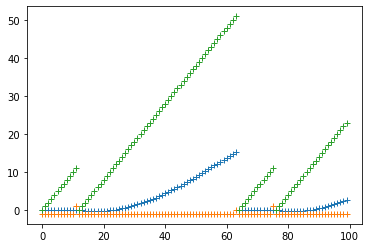

In [8]:
plt.figure()
plt.plot( sim_results['output_x'], '+'  )
plt.plot( sim_results['state'], '+'  )
plt.plot( sim_results['counter'], '+'  )
plt.show()